In [2]:
# Importing necessary libraries
import itertools  # For efficient looping and combinations
import numpy as np  # For numerical operations and array handling
import scipy.stats as stats  # For statistical functions
import matplotlib.pyplot as plt  # For creating visualizations
import sys  # For interacting with the Python interpreter
import copy  # For creating deep copies of objects
import random  # For generating random numbers


In [4]:
#Data
MRPs=dict()
MRPs[0]=20
MRPs[1]=100
MRPs[2]=50
MRPs[3]=50
MRPs[4]=100
MRPs[5]=60
MRPs[6]=35
MRPs[7]=216
MRPs[8]=27
MRPs[9]=130
MRPs[10]=160
MRPs[11]=89
MRPs[12]=73
MRPs[13]=27
MRPs[14]=185
MRPs[15]=249
MRPs[16]=199
MRPs[17]=46
MRPs[18]=55
MRPs[19]=99
'''
MRPs['chocolate']=20
MRPs['shampoo']=100
MRPs['chips']=50
MRPs['pulses']=50
MRPs['apples']=100
MRPs['grapes']=60
MRPs['pepsi']=35
MRPs['bournvita']=216
MRPs['bread']=27
MRPs['jam']=130
MRPs['buscuits']=160
MRPs['butter']=89
MRPs['toothpaste']=73
MRPs['eggs']=27
MRPs['flour']=185
MRPs['peanut_butter']=249
MRPs['cheese']=199
MRPs['milk']=46
MRPs['yoghurt']=55
MRPs['muffins']=99
'''

no_shops=4
no_items=2

actions=range(no_shops)

reward_buying=50

#Bernoulli variable for each shop
bernoulli=np.random.rand(no_shops,no_items)

#Price bias for each shop
bias=np.random.normal(0,5,no_shops)

#Distance Matrix
a = np.random.uniform(1,10,(no_shops,no_shops))
distance_matrix = np.tril(a) + np.tril(a, -1).T
np.fill_diagonal(distance_matrix,0)

print('Distance between shops')
print (distance_matrix)

Distance between shops
[[0.         2.59698811 8.88347083 8.59319838]
 [2.59698811 0.         7.32028624 8.86062286]
 [8.88347083 7.32028624 0.         8.90137297]
 [8.59319838 8.86062286 8.90137297 0.        ]]


In [5]:
def price_penalty(next_state):
    # Setting a scaling factor for the price penalty
    scaling = 0.1
    
   
    shop = next_state[0]  # Shop index
    next_status = next_state[1]  
    
   
    price = 0
    
 
    
    for item_no in range(len(next_status)):
        # Checking if the item is selected in the next status
        if next_state[1][item_no]:
           
            price += np.random.normal(MRPs[item_no] + bias[shop], 1)
    
  
    return -price * scaling


In [13]:
def distance_penalty(distance):
    # Returning the negative distance as penalty
    return -distance


In [12]:
def availability_in_shop(current_state, next_state):
    # Extracting relevant information from the current and next states
    old_status = current_state[1]  # Item status in the current state
    new_status = next_state[1]  # Item status in the next state
    next_shop = next_state[0]  # Shop index in the next state
    
    
    prob = 1
    
 
    for item_no in range(len(old_status)):
       
        if old_status[item_no] == 0:
          
            if new_status[item_no] == 0:
             
                prob *= (1 - bernoulli[next_shop][item_no])
            else:
            
                prob *= bernoulli[next_shop][item_no]
        else:
          
            if new_status[item_no] == 0:
                prob = 0
    
    return prob


In [11]:
def M(shop_b, shop_a):

    temp = sum(sum(np.triu(distance_matrix)))
    
   
    temp2 = (temp - distance_matrix[shop_b, shop_a]) / ((no_shops - 1) * temp)
    

    return temp2

    

In [10]:
# Creating State Space
state_space = []  # List to store all possible states


all_possible_buying_statuses = list(itertools.product([0, 1], repeat=no_items))


for shop_no in range(no_shops):
    for buying_status in all_possible_buying_statuses:
       
        state = (shop_no, buying_status)
        
    
        state_space.append(state)

print('State Space Size')
print(len(state_space))



State Space Size
16


In [14]:
# Defining Transition Probabilities and Rewards
P = dict()  # Dictionary to store transition probabilities
R = dict()  # Dictionary to store rewards

actions = range(no_shops)


for current_state, action, next_state in list(itertools.product(state_space, actions, state_space)):

    if current_state[1] == tuple(np.ones(no_items)):
        P[(current_state, action, next_state)] = 0
        R[(current_state, action, next_state)] = None
        continue

    # Transition within the same shop
    if action == current_state[0]:
        if next_state[0] != current_state[0]:
            P[(current_state, action, next_state)] = 0
            R[(current_state, action, next_state)] = None
        else:
            P[(current_state, action, next_state)] = availability_in_shop(current_state, next_state)
            bought_items = sum(next_state[1])
            if bought_items > 0:
                R[(current_state, action, next_state)] = bought_items * reward_buying + distance_penalty(
                    distance_matrix[current_state[0]][next_state[0]]) + price_penalty(next_state)
            else:
                R[(current_state, action, next_state)] = distance_penalty(
                    distance_matrix[current_state[0]][next_state[0]])
    else:
        # Transition to a different shop
        if next_state[0] == action:
            P[(current_state, action, next_state)] = 0.9 * availability_in_shop(current_state, next_state)
            bought_items = sum(next_state[1])
            if bought_items > 0:
                R[(current_state, action, next_state)] = bought_items * reward_buying + distance_penalty(
                    distance_matrix[current_state[0]][next_state[0]]) + price_penalty(next_state)
            else:
                R[(current_state, action, next_state)] = distance_penalty(
                    distance_matrix[current_state[0]][next_state[0]])
        else:
            # Transition to a different shop with a probability factor 'M'
            P[(current_state, action, next_state)] = 0.1 * availability_in_shop(current_state, next_state) * M(
                next_state[0], current_state[0])
            bought_items = sum(next_state[1])
            if bought_items > 0:
                R[(current_state, action, next_state)] = bought_items * reward_buying + distance_penalty(
                    distance_matrix[current_state[0]][action] + distance_matrix[action][next_state[0]]) + price_penalty(
                    next_state)
            else:
                R[(current_state, action, next_state)] = distance_penalty(
                    distance_matrix[current_state[0]][action] + distance_matrix[action][next_state[0]])

    # Printing information about each transition for clarity
    print("Next transition")
    print(current_state, action, next_state, P[(current_state, action, next_state)], R[(current_state, action, next_state)])


Next transition
(0, (0, 0)) 0 (0, (0, 0)) 0.36426193225145487 -0.0
Next transition
(0, (0, 0)) 0 (0, (0, 1)) 0.05897275403722104 39.1046194368821
Next transition
(0, (0, 0)) 0 (0, (1, 0)) 0.4963998803368511 47.076278257693446
Next transition
(0, (0, 0)) 0 (0, (1, 1)) 0.08036543337447297 85.77301998377848
Next transition
(0, (0, 0)) 0 (1, (0, 0)) 0 None
Next transition
(0, (0, 0)) 0 (1, (0, 1)) 0 None
Next transition
(0, (0, 0)) 0 (1, (1, 0)) 0 None
Next transition
(0, (0, 0)) 0 (1, (1, 1)) 0 None
Next transition
(0, (0, 0)) 0 (2, (0, 0)) 0 None
Next transition
(0, (0, 0)) 0 (2, (0, 1)) 0 None
Next transition
(0, (0, 0)) 0 (2, (1, 0)) 0 None
Next transition
(0, (0, 0)) 0 (2, (1, 1)) 0 None
Next transition
(0, (0, 0)) 0 (3, (0, 0)) 0 None
Next transition
(0, (0, 0)) 0 (3, (0, 1)) 0 None
Next transition
(0, (0, 0)) 0 (3, (1, 0)) 0 None
Next transition
(0, (0, 0)) 0 (3, (1, 1)) 0 None
Next transition
(0, (0, 0)) 1 (0, (0, 0)) 0.012142064408381831 -5.193976229507738
Next transition
(0, (0, 

In [18]:
def takeaction(current_state, action):
    global P  # Global variable for transition probabilities
    global R  # Global variable for rewards
    global state_space  # Global variable for the state space
    
    r = random.random()  # Generating a random number between 0 and 1
    

    for next_state in state_space:
        if r <= 0:
            break
        r -= P[(current_state, action, next_state)]
    
  
    return next_state, R[(current_state, action, next_state)]


In [17]:
def e_greedy(e, Q_s):
    # Generating a random number between 1 and 10
    x = random.randrange(1, 11)


    if x <= e * 10:
        return random.randrange(no_shops)
    else:
      
        return np.argmax(Q_s)


In [15]:
def q_learning(no_episodes, no_steps, alpha, discount, epsilon):
    Q = dict()  # Dictionary to store Q-values
    Rewards = []  # List to store rewards for each episode
    
    # Iterating through the specified number of episodes
    for e in range(no_episodes):
        S = random.choice(state_space)  # Initializing a random state
        step = 0  # Initializing step counter for the current episode
        Episode_Reward = 0  # Initializing total reward for the current episode
        
      
        while step < no_steps:
            
            if S not in Q.keys():
                Q[S] = np.zeros(no_shops).astype(int)
            
           
            if S[1] == tuple(np.ones(no_items)):
                break
            
        
            A = e_greedy(epsilon, Q[S])
            
          
            S_, r = takeaction(S, A)
            
         
            if S_ not in Q.keys():
                Q[S_] = np.zeros(no_shops).astype(int)
            
          
            A_ = np.argmax(Q[S_])
            
          
            if r is None:
                r = 0
            
       
            Q[S][A] = Q[S][A] + alpha * (r + discount * Q[S_][A_] - Q[S][A])
            
         
            S = S_
            step += 1
            
            
            Episode_Reward += r
        
      
        Rewards.append(Episode_Reward)
    
 
    return Q, Rewards


In [19]:
result_Q,Rewards=q_learning(1000,200,0.1,0.9,0.5) 

In [20]:
# Printing the best policy for each state
print("Best Policy for each state")
print("")

# Initializing a dictionary to store the best policy for each state
best_policy = dict()


for state in result_Q:
    best_action = np.argmax(result_Q[state])
    status = state[1]
    
   
    if status == tuple(np.ones(no_items)):
        best_action = "End"
    

    best_policy[state] = best_action
    
    print("State", state, "Best Action", best_action)


Best Policy for each state

State (1, (1, 0)) Best Action 1
State (2, (0, 0)) Best Action 2
State (3, (0, 1)) Best Action 0
State (1, (0, 0)) Best Action 0
State (0, (0, 1)) Best Action 0
State (0, (1, 0)) Best Action 0
State (0, (1, 1)) Best Action End
State (3, (1, 0)) Best Action 3
State (3, (1, 1)) Best Action End
State (1, (1, 1)) Best Action End
State (1, (0, 1)) Best Action 0
State (2, (1, 0)) Best Action 3
State (3, (0, 0)) Best Action 0
State (0, (0, 0)) Best Action 3
State (2, (0, 1)) Best Action 3
State (2, (1, 1)) Best Action End


Test no. 0
Test no. 1
Test no. 2
Test no. 3
Test no. 4
Test no. 5
Test no. 6
Test no. 7
Test no. 8
Test no. 9
Test no. 10
Test no. 11
Test no. 12
Test no. 13
Test no. 14
Test no. 15
Test no. 16
Test no. 17
Test no. 18
Test no. 19
Test no. 20
Test no. 21
Test no. 22
Test no. 23
Test no. 24
Test no. 25
Test no. 26
Test no. 27
Test no. 28
Test no. 29
Test no. 30
Test no. 31
Test no. 32
Test no. 33
Test no. 34
Test no. 35
Test no. 36
Test no. 37
Test no. 38
Test no. 39
Test no. 40
Test no. 41
Test no. 42
Test no. 43
Test no. 44
Test no. 45
Test no. 46
Test no. 47
Test no. 48
Test no. 49
Test no. 50
Test no. 51
Test no. 52
Test no. 53
Test no. 54
Test no. 55
Test no. 56
Test no. 57
Test no. 58
Test no. 59
Test no. 60
Test no. 61
Test no. 62
Test no. 63
Test no. 64
Test no. 65
Test no. 66
Test no. 67
Test no. 68
Test no. 69
Test no. 70
Test no. 71
Test no. 72
Test no. 73
Test no. 74
Test no. 75
Test no. 76
Test no. 77
Test no. 78
Test no. 79
Test no. 80
Test no. 81
Test no. 82
Test no. 83
Te

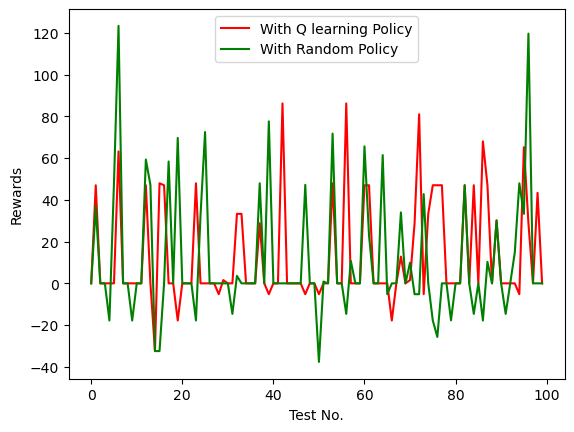

In [21]:
# Lists to store rewards for Q-learning policy and random policy
Rewards_Qpolicy = []
Rewards_RandomPolicy = []

# Running 100 tests
for test_no in range(100):
    print("Test no.", test_no)
    

    S = random.choice(state_space)
    S_random = S
    
    step = 0
    r = 0
    r_random = 0
    
    # Q-learning policy execution
    while S[1] != tuple(np.ones(no_items)) and step < 200:
        A = best_policy[S]  
        S_, rew = takeaction(S, A)
        S = S_
        rew = R[(S, A, S_)]
        
        # Breaking if the reward is None
        if rew is None:
            break
        
        r += rew
        step += 1
    
 
    Rewards_Qpolicy.append(r)
    
    step = 0
    
    # Random policy execution
    while S_random[1] != tuple(np.ones(no_items)) and step < 200:
        A_random = random.choice(actions)  # Choosing a random action
        S_random_, rew = takeaction(S_random, A_random)
        S_random = S_random_
        rew = R[(S_random, A_random, S_random_)]
        
        # Breaking if the reward is None
        if rew is None:
            break
        
        r_random += rew
        step += 1
    
    # Storing the reward for the random policy
    Rewards_RandomPolicy.append(r_random)


print("")
print("Rewards ")
plt.plot(Rewards_Qpolicy, color='r', label='With Q learning Policy')
plt.plot(Rewards_RandomPolicy, color='g', label='With Random Policy')
plt.xlabel('Test No.')
plt.ylabel('Rewards')
plt.legend()
plt.show()



Rewards


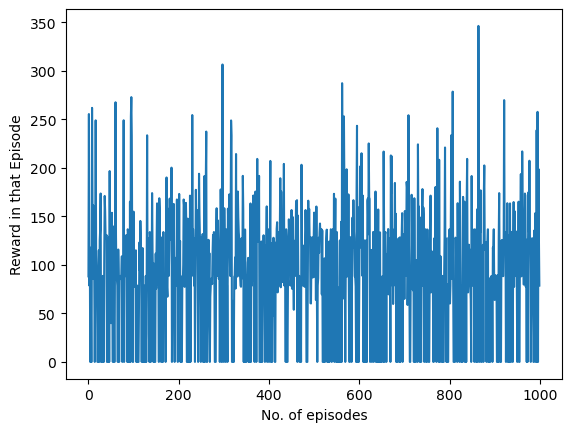

In [20]:
# Plotting rewards over episodes
print("")
print("Rewards")

# Plotting the rewards using Matplotlib
plt.plot(Rewards)
plt.xlabel('No. of episodes')
plt.ylabel('Reward in that Episode')
plt.show()
